# Imports

In [1]:
# Torch
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms

# Python
import random as rand

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Seeding
torch.manual_seed(24)

# CPU/GPU device

In [29]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)
            
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [30]:
# Choose device
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [31]:
print("Device: ", device)

Device:  cpu


# Datasets

### Load

In [2]:
# Load dataset
dataset = dsets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = dsets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Labels
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### Parameters

In [9]:
# Params
batch_size=124
val_size = 5000
train_size = len(dataset) - val_size

### Preparation

In [6]:
# Create train and validation
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [8]:
print("Validation set lenght: ", len(val_dataset))
print("Train set length: ", len(train_dataset))

Validation set lenght:  5000
Train set length:  45000


In [11]:
# Create dataloaders
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size*2, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)

In [28]:
# Move dataloader to device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

# Model

### Config Parameters

In [34]:
input_size = 3*32*32
output_size = 10

### Helper Functions

In [35]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)
    
def my_cross_entropy(x, y):
    prob = x.log_softmax(1)
    log_prob = -1.0 * prob
    loss = log_prob.gather(1, y.unsqueeze(1))
    loss = loss.mean()
    return loss

# Accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Evaluation
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

# Training
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    
    for epoch in range(epochs):
        
        # Training Phase 
        for batch_idx,batch in enumerate(train_loader):
            loss = model.training_step(batch)
            l2_regularization = 0
            l1_regularization = 0
            for param in model.parameters():
                l2_regularization += torch.norm(param)**2
                l1_regularization += torch.sum(torch.abs(param))

            loss = loss + lambda2 * l2_regularization + lambda1 * l1_regularization

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(epoch, 
                                                                     batch_idx * len(batch[0]),
                                                                     len(train_dataset),
                                                                     loss.item()))
                
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

### Model Class

In [111]:
class CIFAR10Model(nn.Module):
    def __init__(self, function):
        # Init
        super().__init__()
        
        # Set activation function
        self.function = function
        
        # 1st hidden layer
        self.linear1 = nn.Linear(input_size, 1536)
        self.linear1_drop = nn.Dropout(0.2)
        
        # 2nd hidden layer
        self.linear2 = nn.Linear(1536, 768)
        self.linear2_drop = nn.Dropout(0.2)
        
        # 3rd hidden layer
        self.linear3 = nn.Linear(768, 576)
        self.linear3_drop = nn.Dropout(0.1)
        
        # Output layer
        self.linear4 = nn.Linear(576, output_size)
    
    def activation(self, input_):
        # Output after activation
        output = None
        
        # Apply activation function
        if self.function == "relu":
            output = torch.nn.functional.relu(input_)
        if self.function == "tanh":
            output = torch.nn.functional.tanh(input_)
        if self.function == "sigmoid":
            output = torch.nn.functional.sigmoid(input_)
        
        return output        
        
    def forward(self, x):
        # Flatten images into vectors
        out = x.view(x.size(0), -1)
                
        # 1st layer propagation
        out = self.activation(self.linear1(out))
        out = self.linear1_drop(out)
                
        # 2nd layer propagation
        out = self.activation(self.linear2(out))
        out = self.linear2_drop(out)
        
        # 3rd layer propagation
        out = self.activation(self.linear3(out))
        out = self.linear3_drop(out)
        
        # Get predictions using output layer
        out = self.linear4(out)
        
        return out
    
    def training_step(self, batch):
        # Unpack batch
        images, labels = batch
        
        # Run forward pass
        out = self.forward(images)
        
        # Compute loss
        loss = my_cross_entropy(out, labels)

        return loss
    
    def validation_step(self, batch):
        # Unpack batch
        images, labels = batch
        
        # Run forward pass
        out = self.forward(images)
        #torch.nn.functional.cross_entropy (out, labels)
        
        # Compute loss
        loss = my_cross_entropy(out, labels)
        
        # Compute accuracy
        acc = accuracy(out, labels)
        
        return {'val_loss': loss, 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

# Plots

In [112]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

In [113]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs')

# Training

In [114]:
# Logging
log_interval = 100

In [115]:
# Regularization
lambda1 = 0
lambda2 = 0.001

#### SGD + tanh

/Users/dailand10/opt/miniconda3/envs/cvl/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Train Epoch: 0 [0/45000]	Loss: 3.250338
Train Epoch: 0 [12400/45000]	Loss: 2.898279
Train Epoch: 0 [24800/45000]	Loss: 2.838905
Train Epoch: 0 [37200/45000]	Loss: 2.583334
Epoch [0], val_loss: 1.8463, val_acc: 0.3476
Train Epoch: 1 [0/45000]	Loss: 2.647557
Train Epoch: 1 [12400/45000]	Loss: 2.811702
Train Epoch: 1 [24800/45000]	Loss: 2.777201
Train Epoch: 1 [37200/45000]	Loss: 2.781892
Epoch [1], val_loss: 1.7857, val_acc: 0.3831
Train Epoch: 2 [0/45000]	Loss: 2.784484
Train Epoch: 2 [12400/45000]	Loss: 2.612975
Train Epoch: 2 [24800/45000]	Loss: 2.714663
Train Epoch: 2 [37200/45000]	Loss: 2.521603
Epoch [2], val_loss: 1.9199, val_acc: 0.2876
Train Epoch: 3 [0/45000]	Loss: 2.706659
Train Epoch: 3 [12400/45000]	Loss: 2.521517
Train Epoch: 3 [24800/45000]	Loss: 2.645594
Train Epoch: 3 [37200/45000]	Loss: 2.512980
Epoch [3], val_loss: 1.7971, val_acc: 0.3565
Train Epoch: 4 [0/45000]	Loss: 2.546398
Train Epoch: 4 [12400/45000]	Loss: 2.368983
Train Epoch: 4 [24800/45000]	Loss: 2.491840
Trai

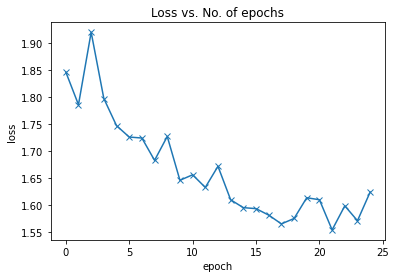

In [116]:
# Model
model = CIFAR10Model("tanh")
model = to_device(model, device)

# Train
history_sgd_tanh = fit(25, 0.06, model, train_loader, val_loader, opt_func=torch.optim.SGD)

# Save
torch.save(model, "sgd_tanh.th")

# Plot
plot_losses(history_sgd_tanh)

In [118]:
evaluate(model, test_loader)

/Users/dailand10/opt/miniconda3/envs/cvl/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


{'val_loss': 1.6628268957138062, 'val_acc': 0.405015766620636}

#### Adadelta + tanh

In [119]:
# history = [evaluate(model, val_loader)]
# #Adadelta and tanh {'val_acc': 0.4410897195339203, 'val_loss': 1.5692006349563599}
# #Adadelta and sigmoid {'val_acc': 0.18444138765335083, 'val_loss': 2.0757439136505127}
# #Adadelta and relu {'val_acc': 0.495879203081131, 'val_loss': 1.4351319074630737}

# Model
model = CIFAR10Model("tanh")
model = to_device(model, device)

# Train
history_adadelta_tanh = fit(25, 0.06, model, train_loader, val_loader,opt_func=torch.optim.Adadelta)

# Save
torch.save(model, "adadelta_tanh.th")

# Plot
plot_losses(history_adadelta_tanh)

/Users/dailand10/opt/miniconda3/envs/cvl/lib/python3.6/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Train Epoch: 0 [0/45000]	Loss: 3.271164
Train Epoch: 0 [12400/45000]	Loss: 2.993495
Train Epoch: 0 [24800/45000]	Loss: 2.806086


KeyboardInterrupt: 

In [ ]:
evaluate(model, test_loader)

#### Adagrad + tanh

In [ ]:
# history = [evaluate(model, val_loader)]
# #Adagrad and tanh {'val_acc': 0.2304287850856781, 'val_loss': 2.1180825233459473}
# #Adagrad and sigmoid {'val_acc': 0.0991738811135292, 'val_loss': 2.3229012489318848}
# #Adagrad and relu {'val_acc': 0.38202202320098877, 'val_loss': 1.717851161956787}


model = CIFAR10Model("relu")
model = to_device(model, device)

history += fit(25, 0.06, model, train_loader, val_loader,opt_func=torch.optim.Adagrad)
plot_losses(history)

In [ ]:
plot_accuracies(history)

In [ ]:
evaluate(model, test_loader)

In [ ]:
history = [evaluate(model, val_loader)]
#Adam and tanh {'val_acc': 0.09625294804573059, 'val_loss': 12.214295387268066}
#Adam and sigmoid {'val_acc': 0.10023604333400726, 'val_loss': 2.4134914875030518}
#Adam and relu {'val_acc': 0.10160306841135025, 'val_loss': 2086.643310546875}
model = CIFAR10Model("relu")
model = to_device(model, device)

history += fit(25, 0.06, model, train_loader, val_loader,opt_func=torch.optim.Adam)
plot_losses(history)

In [ ]:
plot_accuracies(history)

In [ ]:
evaluate(model, test_loader)

In [ ]:
history = [evaluate(model, val_loader)]
#SGD and tanh {'val_acc': 0.4307238459587097, 'val_loss': 1.5837513208389282}
#SGD and sigmoid {'val_acc': 0.16859754920005798, 'val_loss': 2.1040098667144775}
#SGD and relu {'val_acc': 0.46284419298171997, 'val_loss': 1.4877265691757202}
model = CIFAR10Model("relu")
model = to_device(model, device)

history += fit(25, 0.06, model, train_loader, val_loader,opt_func=torch.optim.SGD)
plot_losses(history)

### Confusion Matrix

In [13]:
import numpy as np
cm = np.zeros((10, 10), int)
model = to_device(model, "cpu")
for i in range(len(test_dataset)):
    data = test_dataset[i][0]
    label = test_dataset[i][1]
    data = data.view(1,data.shape[0],data.shape[1],data.shape[2])
    predict = model.forward(data)
    target = label
    cm[predict.argmax(), target] += 1

print(cm)

NameError: name 'to_device' is not defined